In [2]:
import torch
from torch import nn
import numpy as np
import math
from torch.utils import data
from d2l.torch import Animator, Accumulator
import torchvision
from torchvision import transforms

# 生成多项式数据
随机生成0-1均匀分布的数据，因为选择激活函数为RELU所以不能有负数的y，然后产生多项式，由于使用多层感知机，所以效果会比线性模型好很多，所以加大w

In [24]:
np.power(np.full((5, 1), 0.5), np.arange(4))

array([[1.   , 0.5  , 0.25 , 0.125],
       [1.   , 0.5  , 0.25 , 0.125],
       [1.   , 0.5  , 0.25 , 0.125],
       [1.   , 0.5  , 0.25 , 0.125],
       [1.   , 0.5  , 0.25 , 0.125]])

In [3]:
def get_polynomial_data(w, size=1000, max_degree=20):
    true_w = np.zeros(max_degree)
    true_w[:len(w)] = w
    x = np.random.random(size=(size, 1))
    np.random.shuffle(x)
    # 生成多项式矩阵，行为1-20次方
    input_x = np.power(x, np.arange(max_degree))
    for i in range(max_degree):
        input_x[:,i] /= math.gamma(i+1)
    y = input_x.dot(true_w.reshape(-1,1)) + np.random.normal(scale=0.1, size=(input_x.shape[0],1))
    input_x, y = [torch.tensor(data, dtype=torch.float32) for data in [input_x, y]]
    return input_x, y
# len 8
w = [5, 1.2, 3.4, 5.6, 1.2, 2.5, 6.3, 0.1]
polydata, label = get_polynomial_data(w)
test_data, test_label = get_polynomial_data(w)

In [4]:
(label>0).sum()

tensor(1000)

# 多项式拟合——多层感知机Dropout
4层感知机器

In [5]:
def dropout_layer(x, dropout):
    # 若dropout值不满足要求，程序在这里崩溃
    assert 0 <= dropout <= 1
    # 节省资源
    if dropout == 1:
        return torch.zeros_like(x)
    if dropout == 0:
        return x
    mask = (torch.rand(x.shape) > dropout).float()
    return mask*x/(1-dropout)

class Net(nn.Module):
    def __init__(self, input_num, hidden1_num, hidden2_num, output_num, dropout_odds, is_training=True) -> None:
        super().__init__()
        self.input_num = input_num
        self.dropout_odds = dropout_odds
        self.is_training = is_training
        self.flatten = nn.Flatten()
        self.line1 = nn.Linear(input_num, hidden1_num)
        self.line2 = nn.Linear(hidden1_num, hidden2_num)
        self.line3 = nn.Linear(hidden2_num, output_num)
        self.relu = nn.ReLU()
        self.dropout_layer = dropout_layer

    def forward(self, x):
        x = self.flatten(x)
        h1 = self.line1(x.reshape((-1, self.input_num)))
        h1 = self.relu(h1)
        if self.is_training:
            h1 = self.dropout_layer(h1, self.dropout_odds)
        h2 = self.line2(h1)
        h2 = self.relu(h2)
        if self.is_training:
            h2 = self.dropout_layer(h2, self.dropout_odds)
        o = self.line3(h2)

        return o
    def set_is_training(self, is_training):
        self.is_training = is_training
        

In [6]:
def train(polydata, label, input_dim, test_data, test_label):
    def init_weights(m):
        if type == nn.Linear:
            nn.init.normal_(m.weight, std=0.01)
    # 开始时lr=0.1产生了爆炸
    lr = 0.001
    num_epochs = 10
    batch_size = 100
    train_set = data.TensorDataset(polydata[:,:input_dim], label)
    train_iter = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)

    net = Net(input_dim, 8, 8, 1, 0.5)
    # net = nn.Sequential(nn.Linear(input_dim, 1))
    net.apply(init_weights)
    loss = nn.MSELoss(reduction='none')
    updater = torch.optim.SGD(net.parameters(), lr=lr)
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 2], legend=['train loss', 'test loss'])
    
    for i in range(num_epochs):
        metrics = Accumulator(2)
        for x,y in train_iter:   
            y_hat = net(x)
            l = loss(y_hat.reshape(y.shape), y)
            metrics.add(float(l.sum()), y.numel())
            updater.zero_grad()
            l.sum().backward()
            updater.step()
        test_loss = loss(net(test_data[:,:input_dim]), test_label).mean().detach().numpy()
        print(metrics[0], metrics[1], test_loss)
        animator.add(i + 1, (metrics[0]/metrics[1], test_loss))

    return net

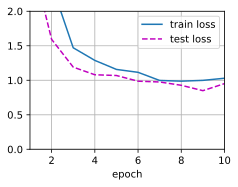

In [7]:
net = train(polydata, label, 4, test_data, test_label)

In [9]:
loss = nn.MSELoss()
net.set_is_training(False)
loss(net(test_data[:,:4]), test_label)

tensor(0.8356, grad_fn=<MseLossBackward0>)

In [13]:
from d2l import torch as d2l
def train(num_epochs=10, batch_size=256, lr = 0.1):
    mnist_train = torchvision.datasets.FashionMNIST(
        root='../data', train=True, transform=transforms.ToTensor(), download=True
    )
    mnist_test = torchvision.datasets.FashionMNIST(
        root='../data', train=False, transform=transforms.ToTensor(), download=True
    )
    train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=4)
    test_iter = data.DataLoader(mnist_test, batch_size,shuffle=True, num_workers=4)
    
    net = Net(28*28, 512, 512, 10, 0.5)
    # net = nn.Sequential(nn.Linear(input_dim, 1))
    loss = nn.CrossEntropyLoss(reduction='none')
    updater = torch.optim.SGD(net.parameters(), lr=lr)
    
    d2l.train_ch6(net, train_iter, test_iter, loss, num_epochs, updater)
train()

training on SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


TypeError: to() received an invalid combination of arguments - got (SGD), but expected one of:
 * (torch.device device, torch.dtype dtype, bool non_blocking, bool copy, *, torch.memory_format memory_format)
 * (torch.dtype dtype, bool non_blocking, bool copy, *, torch.memory_format memory_format)
 * (Tensor tensor, bool non_blocking, bool copy, *, torch.memory_format memory_format)
